# KS

Kolmogorov-Smirnov metric (ks metric) is derived from K-S test. K-S test measures the distance between two plotted cumulative distribution functions (CDF).   
To use it as a metric for classification machine learning problem we see the distance of plotted CDF of target and non-target.  
The model that produces the greatest amount of separability between target and non-target distribution would be considered the better model.  


KS metric ranges from 0 to 100.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [16]:
# sample dataset and sample model

# make sample dataset
X, y = make_classification(
    n_samples=1000, class_sep=0.3, random_state=0
)  # 1000 samples with 20 features

# split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# simple Logistic Model
model = LogisticRegression(random_state=23)
model.fit(X_train, y_train)

# predictions
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]
print(
    f"""{X_train.shape = }\n{y_train.shape = }
        \n{X_test.shape = }\n{y_test.shape = }
        \n{y_train_pred.shape = }\n{y_test_pred.shape = }\n 
    """
)

X_train.shape = (670, 20)
y_train.shape = (670,)
        
X_test.shape = (330, 20)
y_test.shape = (330,)
        
y_train_pred.shape = (670,)
y_test_pred.shape = (330,)
 
    


## KS Table

### Group into Deciles

In [7]:
df = pd.DataFrame()
df["score"] = y_test_pred
# one hot encoding the dependent variable
df["class_0"] = 1 - y_test
df["class_1"] = y_test

# bucket/bin prediction after ordering them
df["bucket"] = pd.qcut(df.score.rank(method="first"), 10, labels=list(range(0, 10, 1)))

df.head()

,score,class_0,class_1,bucket
0,0.314387,1,0,1
1,0.131233,1,0,0
2,0.159981,0,1,0
3,0.350067,1,0,2
4,0.830346,0,1,8


### Target Distribution

In [8]:
grouped = df.groupby("bucket", as_index=False)

ks_table = pd.DataFrame()
ks_table["min_score"] = grouped.min().score
ks_table["max_score"] = grouped.max().score
ks_table["n_class_0"] = grouped.sum().class_0
ks_table["n_class_1"] = grouped.sum().class_1
ks_table["n_total"] = ks_table.n_class_0 + ks_table.n_class_1

ks_table

,min_score,max_score,n_class_0,n_class_1,n_total
0,0.035500,0.224967,21,12,33
1,0.226262,0.327676,27,6,33
2,0.328646,0.377685,19,14,33
3,0.381554,0.437930,25,8,33
4,0.442221,0.491976,23,10,33
5,0.495512,0.575724,17,16,33
6,0.577944,0.671211,9,24,33
7,0.671344,0.757899,6,27,33
8,0.765076,0.874251,4,29,33
9,0.874542,0.988560,7,26,33


```{note}
Sometimes DV: 0 or 1 is called Goods/Bads. Depending on the problem either 0 or 1 is defined as `good`.
```

<AxesSubplot:>

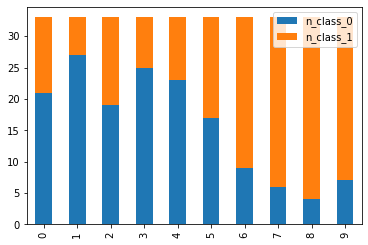

In [9]:
ks_table[
    [
        "n_class_0",
        "n_class_1",
    ]
].plot.bar(stacked=True)

The graph above show the difference in classification for each decicles. 

```{note}
This difference varies depending on performance.
```{list-table}
:header-rows: 1

* - KS 25
  - KS 50
  - KS 75
* - ![alt](../_assets/ks_25.png) 
  - ![alt](../_assets/ks_50.png)
  - ![alt](../_assets/ks_75.png)
```

```

### Calculating KS

In [11]:
count_class_0 = df.class_0.sum()
count_class_1 = df.class_1.sum()

ks_table["%_class_0"] = (ks_table.n_class_0 / count_class_0) * 100
ks_table["%_class_1"] = (ks_table.n_class_1 / count_class_1) * 100

ks_table["cs_class_0"] = (ks_table.n_class_0 / count_class_0).cumsum() * 100
ks_table["cs_class_1"] = (ks_table.n_class_1 / count_class_1).cumsum() * 100

ks_table["cs_diff"] = np.abs(ks_table["cs_class_0"] - ks_table["cs_class_1"])

ks_table.style.format(
    "{:.1f}%", subset=["%_class_0", "%_class_1", "cs_class_0", "cs_class_1", "cs_diff"]
)

,min_score,max_score,n_class_0,n_class_1,n_total,%_class_0,%_class_1,cs_class_0,cs_class_1,cs_diff
0,0.035500,0.224967,21,12,33,13.3%,7.0%,13.3%,7.0%,6.3%
1,0.226262,0.327676,27,6,33,17.1%,3.5%,30.4%,10.5%,19.9%
2,0.328646,0.377685,19,14,33,12.0%,8.1%,42.4%,18.6%,23.8%
3,0.381554,0.437930,25,8,33,15.8%,4.7%,58.2%,23.3%,35.0%
4,0.442221,0.491976,23,10,33,14.6%,5.8%,72.8%,29.1%,43.7%
5,0.495512,0.575724,17,16,33,10.8%,9.3%,83.5%,38.4%,45.2%
6,0.577944,0.671211,9,24,33,5.7%,14.0%,89.2%,52.3%,36.9%
7,0.671344,0.757899,6,27,33,3.8%,15.7%,93.0%,68.0%,25.0%
8,0.765076,0.874251,4,29,33,2.5%,16.9%,95.6%,84.9%,10.7%
9,0.874542,0.988560,7,26,33,4.4%,15.1%,100.0%,100.0%,0.0%


`%_class_0` for 0th bin is 21 / total number of class_0.   
`cs_class_0` is the same but cumulatively summed.  
`cs_diff` is the difference between `cs_class_0` and `cs_class_1`

#### KS

KS is the max difference between cumulatively summed rate of target and cumulatively summed non-target. i.e. maximum value of `cs_diff`

In [17]:
ks = ks_table["cs_diff"].max()
print(f"KS = {round(ks,2)}")

KS = 45.17


### Plot Binned KS

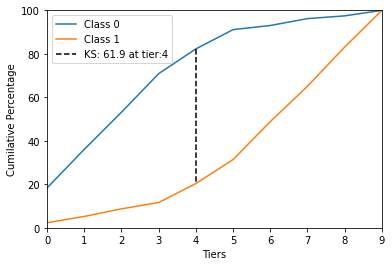

In [24]:
fig, ax = plt.subplots(1, 1)
ax.plot(ks_table["cs_class_0"], label="Class 0")
ax.plot(ks_table["cs_class_1"], label="Class 1")
ks_tier = ks_table["cs_diff"].idxmax()
ax.axvline(
    ks_tier,
    ks_table.loc[ks_tier, "cs_class_0"] / 100,
    ks_table.loc[ks_tier, "cs_class_1"] / 100,
    c="black",
    linestyle="--",
    label=f"KS: {ks_table['cs_diff'].max().round(1)} at tier:{ks_tier}",
)
ax.set_xlim([0.0, 9])
ax.set_ylim([0.0, 100])
ax.set_xlabel("Tiers")
ax.set_ylabel("Cumilative Percentage")
ax.legend()
plt.show()

```{note}
Binned KS are useful when you intent to have different actions for differnt bins. For example in the case of credit scoring you might give a higher APR (interest rate) to people falling in higher bins.
```